In [13]:
from plasma_classes import *
from plasma_utils import *
from matplotlib import pyplot as plt
from matplotlib import animation
from tqdm import tqdm

In [14]:
conc_ion_fluxes = []
conc_electron_fluxes = []
conc_sum_fluxes = []
conc_kinetic_history = []
conc_electric_history = []
conc_summ_history = []

In [15]:
concentrations = []

In [16]:
conc_k = np.linspace(0.05, 1, 20)

In [17]:
for i in range(len(conc_k)):
    L = 1e-2
    N_x = 200
    N_p = 10000
    h = L/N_x
    tau = 2e-13
    n0 = 1e17*conc_k[i]
    concentrations.append(n0)
    n1 = n0*N_x/N_p
    q = 1.60217e-19
    m_e = 9.1093837e-31
    m_i = 1.672e-27*131
    epsilon = 8.85e-12
    T_e = 11600*20
    #temps.append(T_e)
    T_i = 600
    k_b = 1.38e-23
    v_t_e = math.sqrt(3*k_b*T_e/m_e)
    vmin_e = -3*v_t_e
    vmax_e = 3*v_t_e
    v_t_i = math.sqrt(3*k_b*T_i/m_i)
    vmin_i = -3*v_t_i
    vmax_i = 3*v_t_i
    ions = Particles(N_p, n1, q, m_i)
    electrons = Particles(N_p, n1, -q, m_e)
    nodes = Nodes(N_x)
    left_wall = Wall(0, L/10, 0, h, "left")
    right_wall = Wall(9*L/10, L, 0, h, "right")
    walls = (left_wall, right_wall)

    set_homogeneous(electrons, left_wall.right*h, right_wall.left*h)
    set_homogeneous(ions, left_wall.right*h, right_wall.left*h)
    set_distr(electrons, Maxwell(T_e, k_b, m_e), vmin_e, vmax_e, 1000)
    set_distr(ions, Maxwell(T_i, k_b, m_i), vmin_i, vmax_i, 1000)
    electrons.normalise(h, tau)
    ions.normalise(h, tau)
    get_rho(nodes, electrons)
    get_rho(nodes, ions)
    calc_fields(nodes, h, epsilon)
    accel(electrons, nodes, L, h, tau, zerostep=True)
    accel(ions, nodes, L, h, tau, zerostep=True)
    n = 50000
    
    for t in tqdm(range(n)):
        try:
            move(electrons, nodes, consistency=True)
            move(ions, nodes, consistency=True)
        except Exception:
            print("number of iteration: ", t)
            break

        nodes.rho *= 0
        energy_dict = {"electric": [], "kinetic": [], "summ": [], "h": h, "tau": tau}
        account_walls(electrons, walls, Energy=energy_dict, nodes=nodes)
        account_walls(ions, walls, Energy=energy_dict, nodes=nodes)
        get_rho(nodes, electrons)
        get_rho(nodes, ions)
        for wall in walls:
            for particles in wall.particles_lst:
                get_rho(nodes, particles)
        
        calc_fields(nodes, h, epsilon, periodic=True)
        conc_electric_history.append(sum(energy_dict["electric"]))
        accel(electrons, nodes, L, h, tau)
        accel(ions, nodes, L, h, tau)
        conc_kinetic_history.append(sum(energy_dict["kinetic"]))

    for i in range(n):
        conc_summ_history.append(conc_kinetic_history[i] + conc_electric_history[i])

    conc_electron_fluxes.append(N_p-electrons.n_macro)
    conc_ion_fluxes.append(N_p-ions.n_macro)
        

  6%|▌         | 2932/50000 [01:23<22:26, 34.95it/s]


KeyboardInterrupt: 

In [19]:
conc_electron_fluxes = np.array(conc_electron_fluxes)
conc_ion_fluxes = np.array(conc_ion_fluxes)

In [20]:
conc_electric_history = np.array(conc_electric_history)
conc_kinetic_history = np.array(conc_kinetic_history)
conc_summ_history = np.array(conc_summ_history)

In [21]:
conc_electric_history = conc_electric_history.reshape(20, 15000)
conc_kinetic_history = conc_kinetic_history.reshape(20, 15000)
conc_summ_history = conc_summ_history.reshape(20, 15000)

In [30]:
conc_electric_flux = [np.mean(conc_electric_history[i]) for i in range(9)]
conc_kinetic_flux = np.array([np.mean(conc_kinetic_history[i]) for i in range(9)])
conc_summ_flux = [np.mean(conc_summ_history[i]) for i in range(9)]

In [23]:
concentrations = np.array(concentrations)

Text(0.5, 1.0, 'Зависимость потока энергии от концентрации плазмы')

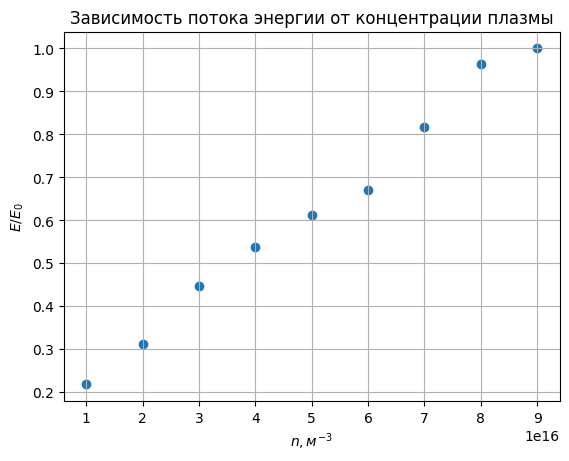

In [29]:
#plt.scatter(concentrations, conc_electric_flux/conc_electric_flux[0], label="electric")
plt.scatter(concentrations, conc_kinetic_flux/conc_kinetic_flux[0], label="kinetic")
#plt.scatter(concentrations, conc_summ_flux/conc_summ_flux[0], label="summ")
plt.grid()
plt.xlabel(r"$n, м^{-3}$")
plt.ylabel(f"$E/E_0$")
plt.title("Зависимость потока энергии от концентрации плазмы")

Text(0.5, 1.0, 'Зависимость потоков частиц от концентрации плазмы')

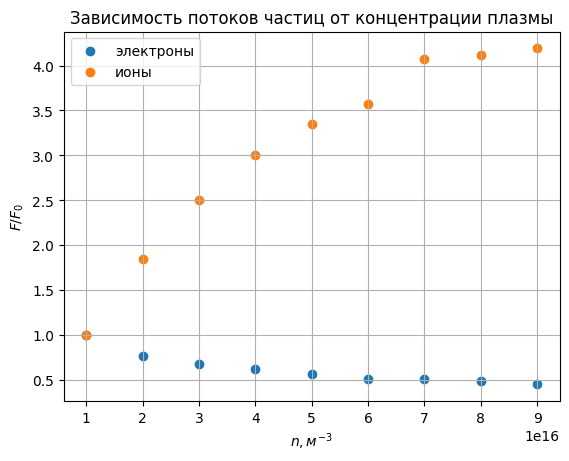

In [25]:
plt.scatter(concentrations, conc_electron_fluxes/conc_electron_fluxes[-1], label="электроны")
plt.scatter(concentrations, conc_ion_fluxes/conc_ion_fluxes[-1], label="ионы")
plt.legend()
plt.grid()
plt.xlabel(r"$n, м^{-3}$")
plt.ylabel(f"$F/F_0$")
plt.title("Зависимость потоков частиц от концентрации плазмы")

In [31]:
import os

In [32]:
def save_array_to_file(np_array, filename):
    with open(filename, 'w') as f:
        for float_value in np_array:
            f.write(f"{float_value}\n")

def read_array_from_file(filename):
    if not os.path.exists(filename):
        raise FileNotFoundError(f"{filename} not found")

    float_list = []
    with open(filename, 'r') as f:
        for line in f:
            float_list.append(float(line.strip()))

    return np.array(float_list)

In [33]:
save_array_to_file(conc_kinetic_flux, "conc_kinetic")
save_array_to_file(concentrations, "concentrations")
save_array_to_file(conc_electron_fluxes, "conc_electron_fluxes")
save_array_to_file(conc_ion_fluxes, "conc_ion_fluxes")
